<a href="https://colab.research.google.com/github/azzedbenj007/AgentGPT/blob/main/ModelePredictifConsommationElectrique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#PARTIE 1 : INSTALLATION ET IMPORTATION DES BIBLIOTHÈQUES

# Le "!" permet d'exécuter des commandes système directement dans Colab.

!pip install pandas matplotlib seaborn statsmodels pmdarima scikit-learn

In [2]:
# Importation des bibliothèques qui seront utilisées dans le reste du script

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import numpy as np

from google.colab import files # Spécifique à Google Colab pour l'upload

In [3]:
# Configuration esthétique pour les graphiques

sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = (15, 7)

print(" Bibliothèques installées et importées avec succès.")

 Bibliothèques installées et importées avec succès.


Génération d'une base de données simulée de consommation électrique...

✅ Fichier 'consommation_hopital_simulee.csv' créé avec succès !
Le fichier contient 1095 lignes de données.

Aperçu des données générées :
       temps  consommation_kwh
0 2020-01-01             17271
1 2020-01-02             17913
2 2020-01-03             16251
3 2020-01-04             15056
4 2020-01-05             12509

Visualisation des données générées...


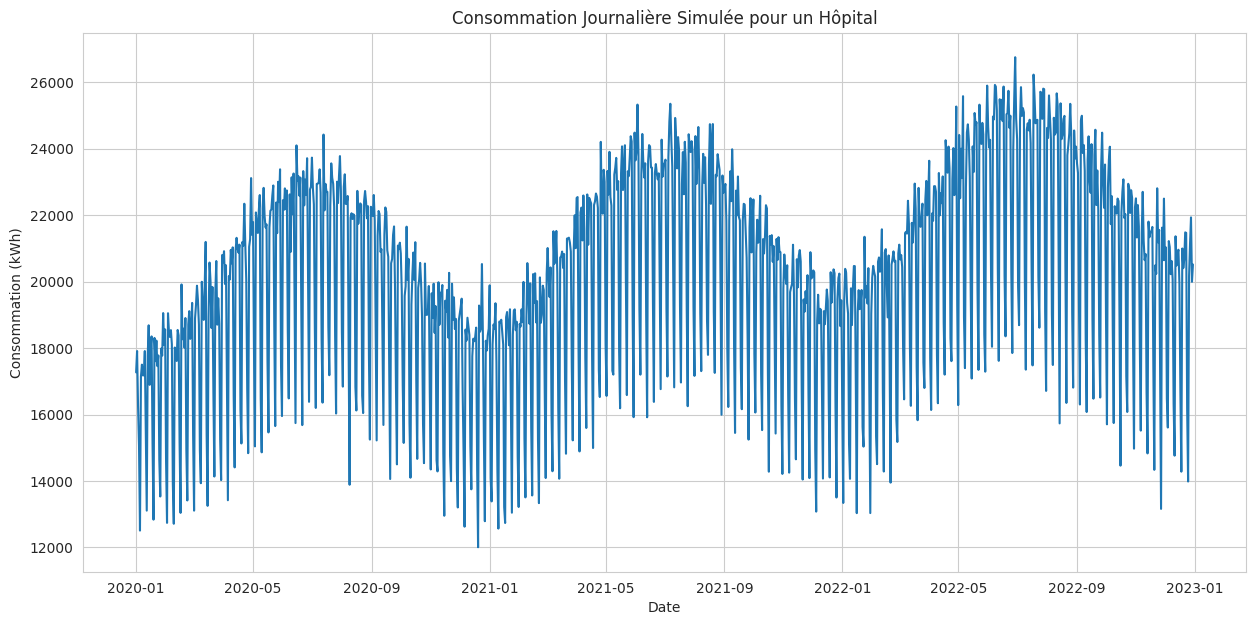

In [4]:
# =============================================================================
# CELLULE DE GÉNÉRATION DE LA BASE DE DONNÉES SIMULÉE
# =============================================================================
import pandas as pd
import numpy as np

print("Génération d'une base de données simulée de consommation électrique...")

# --- Paramètres de la simulation ---
num_days = 3 * 365  # 3 ans de données
start_date = '2020-01-01'
base_consumption = 20000  # Consommation de base en kWh/jour
trend_factor = 3          # Augmentation journalière de 3 kWh (tendance de fond)
annual_amplitude = 2500   # Amplitude de la variation saisonnière annuelle (chauffage/clim)
noise_level = 600         # Fluctuation aléatoire journalière en kWh

# --- Création de la série temporelle ---
# 1. Créer l'index de dates
date_index = pd.to_datetime(pd.date_range(start=start_date, periods=num_days, freq='D'))

# 2. Créer la tendance linéaire
trend = np.arange(num_days) * trend_factor

# 3. Créer la saisonnalité annuelle (cycle de 365.25 jours)
# On décale la phase (-90) pour que le pic soit en été.
annual_seasonality = annual_amplitude * np.sin((np.arange(num_days) - 90) * 2 * np.pi / 365.25)

# 4. Créer la saisonnalité hebdomadaire (cycle de 7 jours)
# L'activité est plus faible le week-end (Samedi = jour 5, Dimanche = jour 6)
day_of_week = date_index.dayofweek # Lundi=0, ..., Dimanche=6
weekly_multiplier = np.ones(num_days)
# Réduction de 20% le samedi et 30% le dimanche
weekly_multiplier[day_of_week == 5] = 0.80
weekly_multiplier[day_of_week == 6] = 0.70

# 5. Créer le bruit aléatoire
noise = np.random.normal(0, noise_level, num_days)

# --- Combinaison des composantes ---
# La saisonnalité hebdomadaire multiplie la consommation de base, les autres s'ajoutent.
consommation_kwh = (base_consumption + annual_seasonality + trend) * weekly_multiplier + noise

# --- Création du DataFrame final ---
df_simulated = pd.DataFrame({
    'temps': date_index,
    'consommation_kwh': consommation_kwh
})

# S'assurer qu'il n'y a pas de valeurs négatives et arrondir à l'entier
df_simulated['consommation_kwh'] = df_simulated['consommation_kwh'].clip(lower=0).astype(int)

# --- Sauvegarde du fichier CSV ---
filename = 'consommation_hopital_simulee.csv'
df_simulated.to_csv(filename, index=False)

print(f"\n✅ Fichier '{filename}' créé avec succès !")
print(f"Le fichier contient {len(df_simulated)} lignes de données.")
print("\nAperçu des données générées :")
print(df_simulated.head())

# Visualisation rapide pour vérifier le réalisme
print("\nVisualisation des données générées...")
plt.figure(figsize=(15,7))
plt.plot(df_simulated['temps'], df_simulated['consommation_kwh'])
plt.title('Consommation Journalière Simulée pour un Hôpital')
plt.xlabel('Date')
plt.ylabel('Consommation (kWh)')
plt.show()

In [ ]:
#

#PARTIE 2 : CHARGEMENT DE VOTRE FICHIER DE DONNÉES

# ==

#print("Veuillez choisir votre fichier CSV contenant les colonnes 'temps' et 'consommation_kwh'.")
#uploaded = files.upload()

In [ ]:
# On récupère le nom du fichier que vous venez de téléverser

# Ceci est important pour que le code fonctionne avec n'importe quel nom de fichier.

#filename = next(iter(uploaded))

#print(f"\nFichier '{filename}' chargé avec succès.")

In [5]:
# PARTIE 3 : PRÉPARATION ET NETTOYAGE DES DONNÉES

# Lire le fichier CSV chargé à l'étape précédente en utilisant son nom
#df = pd.read_csv(filename)
# Lire le fichier CSV généré
df = pd.read_csv('consommation_hopital_simulee.csv')

In [6]:
#1. Renommer les colonnes pour plus de clarté

df.columns = ['temps', 'consommation_kwh']

In [7]:
# 2. Convertir la colonne 'temps' en objet datetime, essentiel pour les séries temporelles
df['temps'] = pd.to_datetime(df['temps'])

In [8]:
# 3. Définir la colonne 'temps' comme index du DataFrame
df.set_index('temps', inplace=True)

In [9]:
# 4. Gérer les valeurs manquantes (suppression des lignes concernées)
print(f"Taille du jeu de données avant nettoyage : {df.shape[0]} lignes.")
missing_values_before = df.isnull().sum().sum()
print(f"Nombre de valeurs manquantes trouvées : {missing_values_before}")

Taille du jeu de données avant nettoyage : 1095 lignes.
Nombre de valeurs manquantes trouvées : 0


In [10]:
df.dropna(inplace=True)

In [11]:

print(f"Taille du jeu de données après nettoyage : {df.shape[0]} lignes.")
print("\n Données chargées et nettoyées.")

Taille du jeu de données après nettoyage : 1095 lignes.

 Données chargées et nettoyées.


In [12]:
# Affichage des 5 premières lignes pour vérifier
print("\nAperçu des données :")

print(df.head())


Aperçu des données :
            consommation_kwh
temps                       
2020-01-01             17271
2020-01-02             17913
2020-01-03             16251
2020-01-04             15056
2020-01-05             12509


--- DÉBUT DE L'ANALYSE EXPLORATOIRE ---

Graphique 1: Consommation Électrique Journalière (kWh)


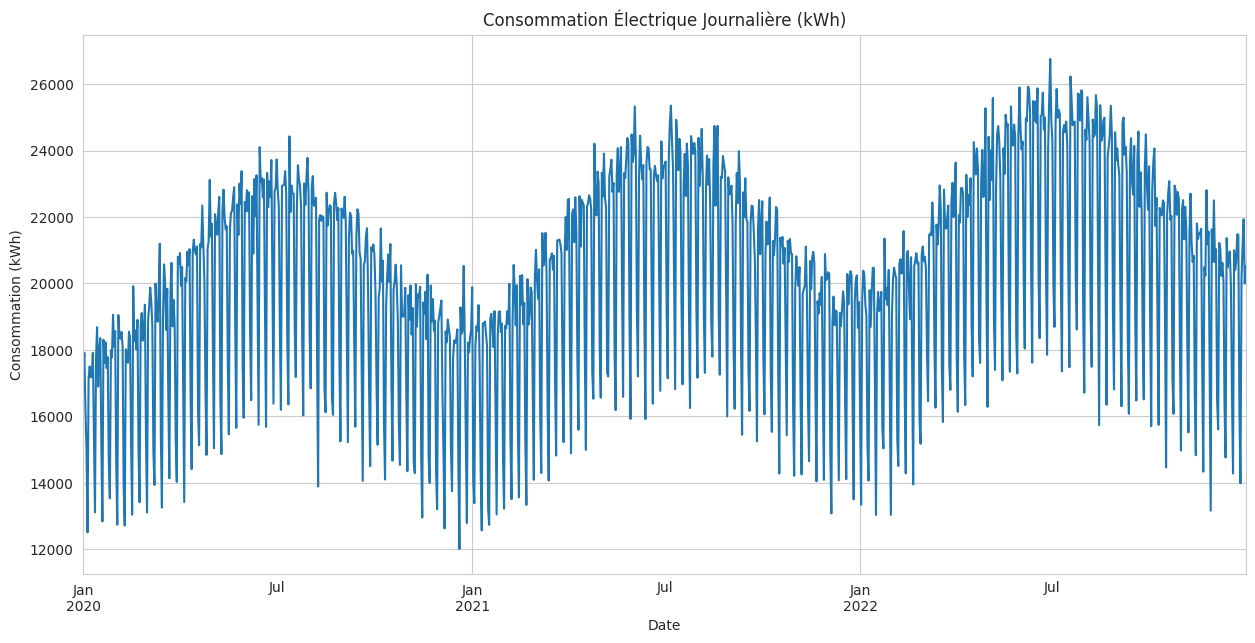

In [13]:
# PARTIE 4 : ANALYSE EXPLORATOIRE (EDA)
print("--- DÉBUT DE L'ANALYSE EXPLORATOIRE ---")
# 1. Visualisation de la série temporelle complète

print("\nGraphique 1: Consommation Électrique Journalière (kWh)")

df['consommation_kwh'].plot(title='Consommation Électrique Journalière (kWh)')

plt.ylabel('Consommation (kWh)')

plt.xlabel('Date')

plt.show()


Graphique 2 : Décomposition de la série temporelle


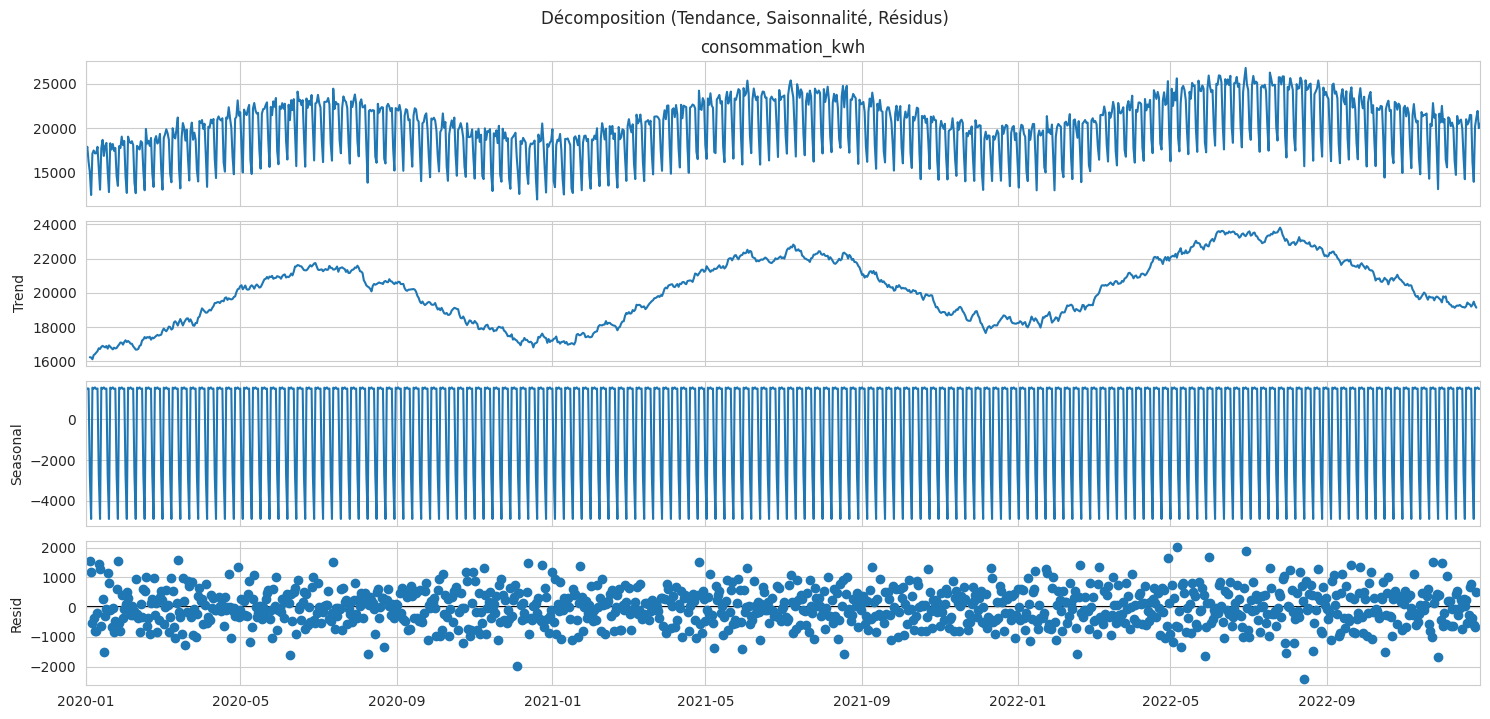

In [14]:
# 2. Décomposition de la série temporelle (Tendance, Saisonnalité, Résidus) # period=7 car on suspecte un cycle hebdomadaire dans les données journalières.

print("\nGraphique 2 : Décomposition de la série temporelle")

decomposition = seasonal_decompose(df['consommation_kwh'], model='additive', period=7)

fig = decomposition.plot()

plt.suptitle('Décomposition (Tendance, Saisonnalité, Résidus)', y=1.02)
plt.show()

In [15]:
# 3. Test de stationnarité (Test de Dickey-Fuller Augmenté)

print("\nAnalyse 3: Test de stationnarité (ADF)")

result = adfuller(df['consommation_kwh'])

print(f'P-value: {result[1]:.4f}')

if result[1] < 0.05:
  print("Conclusion : La série semble stationnaire (p-value < 0.05).")
else:
  print("Conclusion : La série n'est probablement pas stationnaire. Le modèle SARIMA s'en chargera.")


Analyse 3: Test de stationnarité (ADF)
P-value: 0.3190
Conclusion : La série n'est probablement pas stationnaire. Le modèle SARIMA s'en chargera.


In [16]:
#PARTIE 5 : SÉPARATION DES DONNÉES (ENTRAÎNEMENT / TEST)

#On garde les 90 derniers jours pour le test. Vous pouvez changer cette valeur.
split_point = len(df) - 90

train_data = df.iloc[:split_point]

test_data = df.iloc[split_point:]

In [17]:
print(f"Taille totale des données : {len(df)} points")

print(f"Taille du jeu d'entraînement : {len(train_data)} points")

print(f"Taille du jeu de test : {len(test_data)} points")

Taille totale des données : 1095 points
Taille du jeu d'entraînement : 1005 points
Taille du jeu de test : 90 points



Visualisation de la séparation des données :


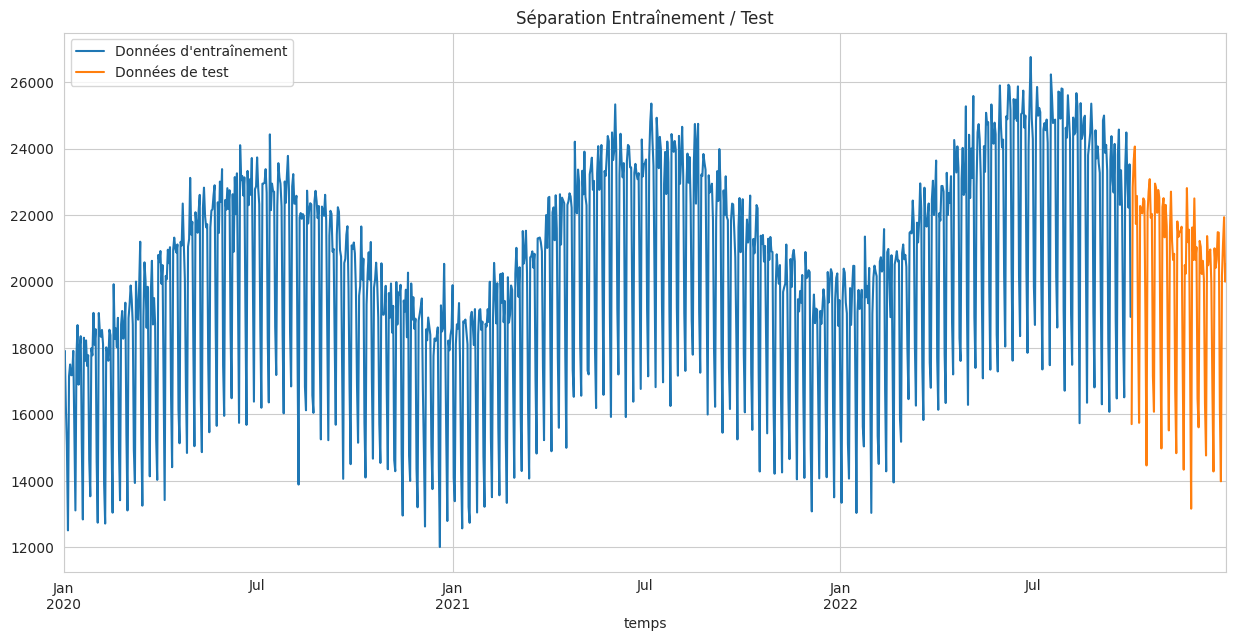

In [18]:
# Visualisation de la séparation

print("\nVisualisation de la séparation des données :")

plt.figure()

train_data ['consommation_kwh'].plot(label='Données d\'entraînement', title='Séparation Entraînement / Test')
test_data['consommation_kwh'].plot(label='Données de test')

plt.legend()

plt.show()

In [19]:
# PARTIE 6 : CRÉATION ET ENTRAÎNEMENT DU MODÈLE PRÉDICTIF (SARIMA)
print("Recherche des meilleurs paramètres pour le modèle SARIMA...")
print("Ceci peut prendre quelques instants...")

Recherche des meilleurs paramètres pour le modèle SARIMA...
Ceci peut prendre quelques instants...


In [ ]:
#`auto_arima` va trouver les meilleurs paramètres (p,d,q) (P,D,Q)m.
# m=7 indique une saisonnalité hebdomadaire (7 jours).

auto_model = pm.auto_arima(train_data['consommation_kwh'],

                           seasonal=True,
                           m=7,
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore',
                           trace=True) # Affiche les modèles testés

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=7.10 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19022.186, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=inf, Time=3.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17869.455, Time=2.57 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19020.186, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=18706.730, Time=0.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=16372.241, Time=3.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=7.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=17154.529, Time=6.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=17495.444, Time=6.73 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=16437.781, Time=5.32 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=8.58 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=16581.678, Time=2.66 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.05 sec


In [21]:
print("\n--- MEILLEUR MODÈLE TROUVÉ ---")
print(auto_model.summary())


--- MEILLEUR MODÈLE TROUVÉ ---
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1005
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -8055.809
Date:                           Mon, 07 Jul 2025   AIC                          16119.617
Time:                                   19:58:36   BIC                          16139.264
Sample:                               01-01-2020   HQIC                         16127.083
                                    - 10-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8471      0.009    -89.509      0.000      -0.866      -0.829
ar.S.L7    

In [22]:
model = auto_model # Le modèle est déjà entraîné et prêt à l'emploi.

In [23]:
# PARTIE 7 : PRÉDICTION ET ÉVALUATION DU MODÈLE
print("--- PRÉDICTION SUR LA PÉRIODE DE TEST ---")

--- PRÉDICTION SUR LA PÉRIODE DE TEST ---


In [24]:
# Génération des prédictions pour la période de test

n_periods = len(test_data)

predictions, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

In [25]:
#Création d'un DataFrame pour les prédictions pour faciliter la visualisation
predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=['predictions'])

In [26]:
# Calcul des métriques d'évaluation
rmse = np.sqrt(mean_squared_error(test_data['consommation_kwh'], predictions_df['predictions']))
mape = mean_absolute_percentage_error(test_data['consommation_kwh'], predictions_df['predictions'])

In [27]:
print(f"\n--- ÉVALUATION DE LA PERFORMANCE ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} kWh")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2%}")
print(f"Cela signifie qu'en moyenne, l'erreur du modèle est de {mape:.2%}.")


--- ÉVALUATION DE LA PERFORMANCE ---
RMSE (Root Mean Squared Error): 985.05 kWh
MAPE (Mean Absolute Percentage Error): 4.24%
Cela signifie qu'en moyenne, l'erreur du modèle est de 4.24%.



Graphique final: Prédictions du modèle vs Données réelles


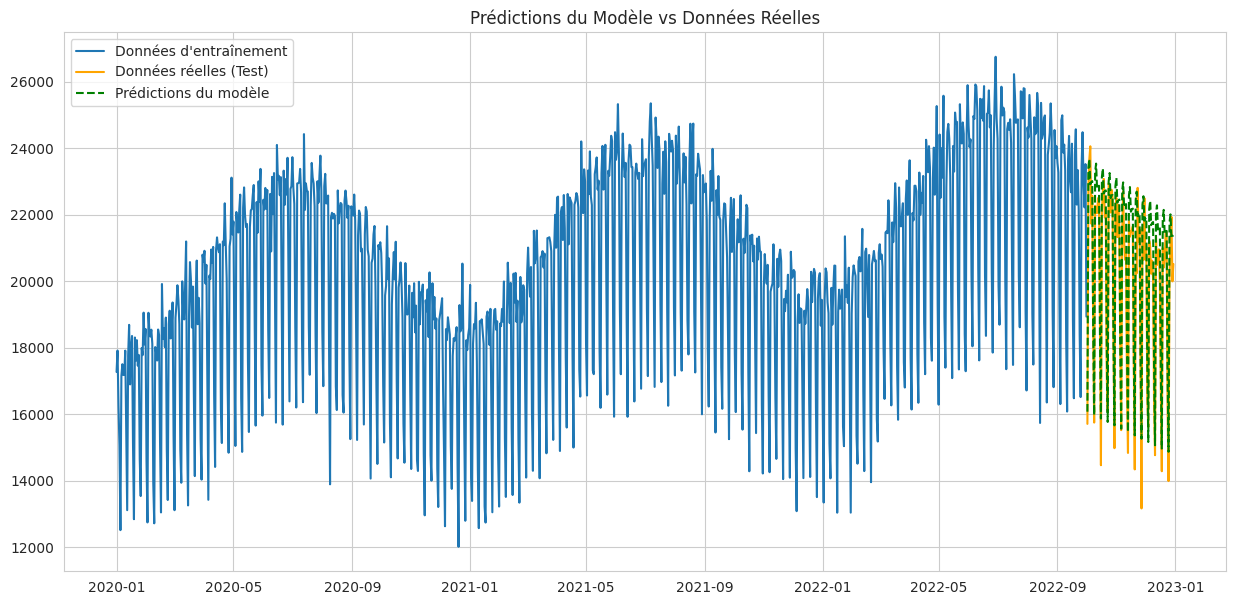

In [28]:
# Visualisation finale : comparaison des données réelles et des prédictions

print("\nGraphique final: Prédictions du modèle vs Données réelles")
plt.figure()

plt.plot(train_data['consommation_kwh'], label='Données d\'entraînement')

plt.plot(test_data['consommation_kwh'], label='Données réelles (Test)', color='orange')

plt.plot(predictions_df['predictions'], label='Prédictions du modèle', color='green', linestyle='--')
plt.title('Prédictions du Modèle vs Données Réelles')

plt.legend()

plt.show()